In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Iteration 4').getOrCreate()

from pyspark.ml.classification import LogisticRegression

In [2]:
data = spark.read.csv('./balanced.csv',inferSchema=True,header=True)

In [3]:
# Print data schema.
data.printSchema()

# Print data columns.
data.columns

root
 |-- age: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- blood pressure: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- cardio: integer (nullable = true)



['age', 'weight', 'blood pressure', 'cholesterol', 'gluc', 'cardio']

In [4]:
my_cols = data.select(['age',
 'weight',
 'blood pressure',
 'cholesterol',
 'gluc',
 'cardio'])

In [5]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [6]:
assembler = VectorAssembler(
    inputCols=['age',
             'weight',
             'blood pressure',
             'cholesterol',
             'gluc'],
            outputCol='features')

In [7]:
from pyspark.ml import Pipeline

###### Logistic Regression

In [8]:
lr = LogisticRegression(featuresCol='features',labelCol='cardio')

pipeline = Pipeline(stages=[assembler,lr])

In [9]:
train_data, test_data = data.randomSplit([0.8,0.2])

In [10]:
print(train_data.count())
train_data.show()

49349
+---+------+--------------+-----------+----+------+
|age|weight|blood pressure|cholesterol|gluc|cardio|
+---+------+--------------+-----------+----+------+
| 39|  45.0|             1|          1|   1|     0|
| 39|  45.0|             3|          2|   1|     0|
| 39|  46.0|             1|          1|   1|     0|
| 39|  50.0|             1|          1|   1|     0|
| 39|  50.0|             1|          1|   1|     0|
| 39|  50.0|             1|          1|   1|     0|
| 39|  50.0|             3|          1|   1|     0|
| 39|  51.0|             3|          1|   1|     0|
| 39|  52.0|             1|          1|   1|     0|
| 39|  52.0|             2|          1|   1|     0|
| 39|  52.0|             3|          1|   1|     0|
| 39|  52.0|             4|          1|   1|     1|
| 39|  53.0|             1|          1|   1|     0|
| 39|  53.0|             1|          1|   1|     0|
| 39|  53.0|             1|          1|   1|     1|
| 39|  53.0|             3|          1|   3|     0|
| 39| 

In [11]:
print(test_data.count())
test_data.show()

12387
+---+------+--------------+-----------+----+------+
|age|weight|blood pressure|cholesterol|gluc|cardio|
+---+------+--------------+-----------+----+------+
| 30|  59.0|             1|          1|   1|     0|
| 30|  59.0|             3|          1|   1|     0|
| 30|  59.0|             3|          1|   1|     0|
| 39|  47.0|             3|          1|   1|     0|
| 39|  49.0|             1|          1|   1|     0|
| 39|  53.0|             3|          1|   1|     0|
| 39|  54.0|             1|          1|   1|     0|
| 39|  57.0|             1|          1|   1|     0|
| 39|  57.0|             1|          1|   1|     0|
| 39|  58.0|             3|          1|   1|     0|
| 39|  59.0|             1|          1|   1|     0|
| 39|  60.0|             1|          2|   1|     0|
| 39|  60.0|             3|          1|   1|     0|
| 39|  61.0|             3|          2|   2|     0|
| 39|  62.0|             3|          1|   1|     0|
| 39|  62.0|             3|          1|   1|     0|
| 39| 

In [12]:
fit_model = pipeline.fit(train_data)

results = fit_model.transform(test_data)

In [13]:
results.select('cardio','prediction').show()

+------+----------+
|cardio|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')
AUC = my_eval.evaluate(results)

AUC

0.6820643918318035

###### Random Forest

In [15]:
output = assembler.transform(data)

data = output.select('features','cardio')

train_data,test_data = data.randomSplit([0.8,0.2])

In [16]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol='cardio',featuresCol='features',numTrees=100)

rfc_model = rfc.fit(train_data)

rfc_predictions = rfc_model.transform(test_data)

In [17]:
rfc_predictions.select('cardio','prediction').show()

+------+----------+
|cardio|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [18]:
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'cardio')

In [19]:
print("RFC")
print(my_binary_eval.evaluate(rfc_predictions))

RFC
0.7585096098364721


###### 7.3 Search for patterns

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

rf = rfc_predictions.select('features','prediction').toPandas()
rf.to_csv("rf_predict.csv",index=False)

lr = results.select('features','prediction').toPandas()
lr.to_csv("lr_predict.csv", index=False)

In [21]:
import pandas as pd
pdf_rf = pd.read_csv("./rf__predict.csv")
pdf_lr = pd.read_csv("./lr__predict.csv")

Text(0.5,1,'Random Forest')

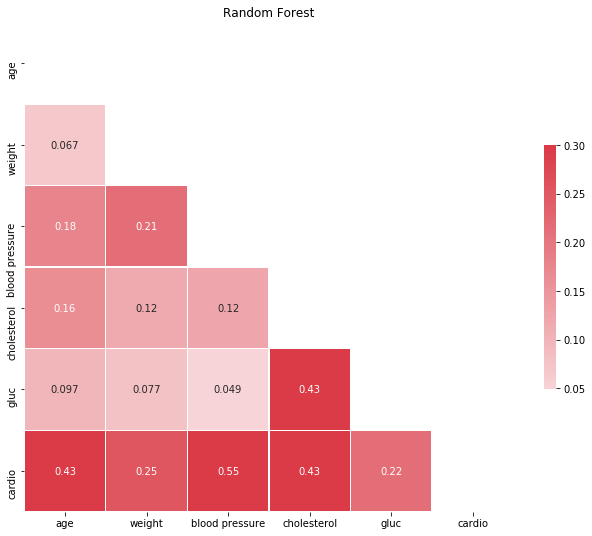

In [22]:
import seaborn as sns

corr1 = pdf_rf.corr(method='pearson')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
             square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title('Random Forest')

Text(0.5,1,'Logistic Regression')

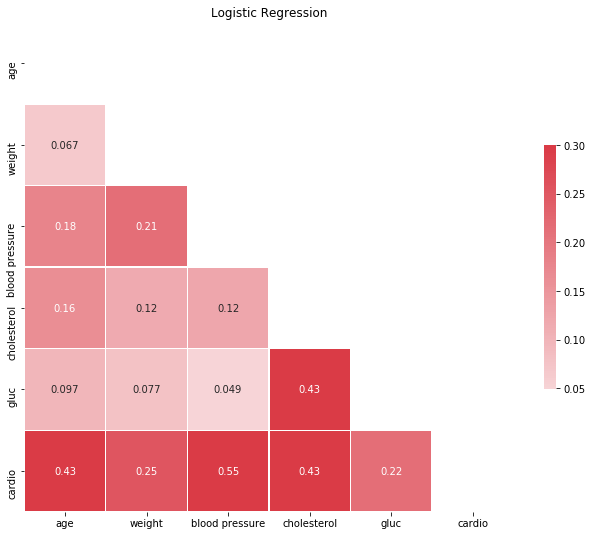

In [23]:
corr2 = pdf_rf.corr(method='pearson')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
             square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title('Logistic Regression')